<a href="https://colab.research.google.com/github/kwlaial/Music_Sentiment_Detection_to_Images/blob/main/Music_Sentiment_Detection_to_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Music Sentiment Detection to Images

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle
!cd /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!ls -l /root/.kaggle/kaggle.json

-rw-r--r-- 1 root root 63 Mar 25 10:36 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d cakiki/muse-the-musical-sentiment-dataset

100% 6.96M/6.96M [00:01<00:00, 8.54MB/s]
100% 6.96M/6.96M [00:01<00:00, 5.25MB/s]


**CNNs**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split

In [ ]:
# Load the dataset
df = pd.read_csv("/content/muse-the-musical-sentiment-dataset.zip")

In [ ]:
# Split the dataset into inputs (valence, arousal, and dominance) and outputs (seed labels)
X = df[['valence_tags','arousal_tags','dominance_tags']].values
Y = df['seeds'].str.split(',').apply(lambda x: [s.strip() for s in x]).values

In [ ]:
# Preprocess the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert the seed labels to a binary matrix
from sklearn.preprocessing import MultiLabelBinarizer
label_binarizer = MultiLabelBinarizer()
Y_binary = label_binarizer.fit_transform(Y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_binary, test_size=0.2)

In [ ]:
# Tokenize the input data and pad the sequences to a fixed length
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
X_train_list = [','.join(map(str, row)) for row in X_train]
X_test_list = [','.join(map(str, row)) for row in X_test]
tokenizer.fit_on_texts(X_train_list)
X_train_tokenized = tokenizer.texts_to_sequences(X_train_list)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_list)
X_train_padded = pad_sequences(X_train_tokenized, padding='post')
X_test_padded = pad_sequences(X_test_tokenized, padding='post', maxlen=X_train_padded.shape[1])

In [ ]:
# Build the RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, 16, input_length=X_train_padded.shape[1]))
model.add(LSTM(32))
model.add(Dense(Y_train.shape[1], activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_padded, Y_test, return_dict=False)
print(f"Test loss: {test_loss:.4f} - Test accuracy: {test_acc:.4f}")

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1800/1800 [==============================] - 17s 7ms/step - loss: 0.0315 - accuracy: 0.0083 - val_loss: 0.0096 - val_accuracy: 0.0087
Epoch 2/10
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0093 - accuracy: 0.0090 - val_loss: 0.0096 - val_accuracy: 0.0078
Epoch 3/10
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0093 - accuracy: 0.0094 - val_loss: 0.0096 - val_accuracy: 0.0102
Epoch 4/10
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0093 - accuracy: 0.0089 - val_loss: 0.0095 - val_accuracy: 0.0090
Epoch 5/10
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0090 - accuracy: 0.0150 - val_loss: 0.0093 - val_accuracy: 0.0172
Epoch 6/10
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0085 - accuracy: 0.0185 - val_loss: 0.0092 - val_accuracy: 0.0181
Epoch 7/10
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0082 - accuracy: 0.0251 - val_loss: 0.0092 - val_accuracy: 0.011

In [ ]:
# Save the trained model to file
model.save('/content/drive/MyDrive/my_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the saved model
model = load_model('/content/drive/MyDrive/my_model.h5')

# Load the scaler used to preprocess the data
scaler = MinMaxScaler()
scaler.fit(X_train)  # where X_train is the training data used to train the model

# Take in user input for valence, arousal, and dominance
valence = float(input("Enter valence: "))
arousal = float(input("Enter arousal: "))
dominance = float(input("Enter dominance: "))

# Preprocess the user input
input_data = np.array([[valence, arousal, dominance]])
input_data_scaled = scaler.transform(input_data)

# Modify the input layer of the model
model.layers[0].batch_input_shape = (None, 3)

# Make a prediction using the modified model
prediction = model.predict(input_data_scaled)

# Print the predicted seed labels
print("Predicted seed labels: ", prediction)

Enter valence: 1
Enter arousal: 2
Enter dominance: 3


ValueError: ignored

In [ ]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Print the size of each set
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 72000
Test set size: 18001


Feedforward neural networks: Also known as multi-layer perceptrons (MLPs), these neural networks consist of an input layer, one or more hidden layers, and an output layer. Each layer is composed of nodes (neurons) that perform mathematical operations on the input data. MLPs can be used for multi-label classification by modifying the output layer to have multiple nodes, with each node representing a different label.

Convolutional neural networks (CNNs): These neural networks are commonly used for image classification tasks, but can also be adapted for multi-label classification. CNNs consist of multiple convolutional layers that extract features from the input data, followed by one or more fully connected layers that perform classification. CNNs can be used for multi-label classification by modifying the output layer to have multiple nodes, with each node representing a different label.

Recurrent neural networks (RNNs): These neural networks are commonly used for sequential data, such as natural language processing and speech recognition. RNNs consist of a hidden state that is updated at each time step, allowing the network to remember information from previous time steps. RNNs can be used for multi-label classification by modifying the output layer to have multiple nodes, with each node representing a different label.

Transformer-based neural networks: These neural networks are a type of neural network architecture that is commonly used for natural language processing tasks, such as language translation and text classification. Transformer-based neural networks consist of a self-attention mechanism that allows the network to attend to different parts of the input data, followed by one or more fully connected layers that perform classification. Transformer-based neural networks can be used for multi-label classification by modifying the output layer to have multiple nodes, with each node representing a different label.

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['seeds'])
train_sequences = tokenizer.texts_to_sequences(train_df['seeds'])
test_sequences = tokenizer.texts_to_sequences(test_df['seeds'])

In [ ]:
# Pad the sequences to a fixed length
max_length = 100
train_data = sequence.pad_sequences(train_sequences, maxlen=max_length)
test_data = sequence.pad_sequences(test_sequences, maxlen=max_length)

In [ ]:
# Initialize a LabelBinarizer object
label_binarizer = LabelBinarizer()

# Fit the binarizer to the training set and transform the target variable
train_y = label_binarizer.fit_transform(train_df['seeds'])

# Transform the target variable in the testing set, handling unseen labels
test_y = label_binarizer.transform(test_df['seeds'])

# Print the unique labels in the target variable
print("Unique labels:", label_binarizer.classes_)

Unique labels: ["['acerbic', 'bittersweet']" "['acerbic', 'exciting']"
 "['acerbic', 'ironic']" ... "['yearning', 'tender']"
 "['yearning', 'whimsical']" "['yearning']"]


Decision trees

Random Forest

SVM

# Music21


In [ ]:
import music21


In [ ]:
# Load a MIDI file
midi_file = music21.midi.MidiFile()
midi_file.open('/content/Chopin_Frédéric__François_-_Fantaisie_Improptu_Lilium100.mid')
midi_file.read()
midi_file.close()

# Convert the MIDI data to a music21 Stream object
stream = music21.midi.translate.midiTrackToStream(midi_file.tracks[0])


In [ ]:
# Analyze the key and mode
key = stream.analyze('key')
print("Key and mode: {} {}".format(key.tonic.name, key.mode))

Key and mode: C# major


In [ ]:
# Analyze the chords
chords = stream.chordify()
for chord in chords.recurse().getElementsByClass(music21.chord.Chord):
    print("Chord: {} {}".format(chord.root().name, chord.quality))

Chord: G# other
Chord: G# other
Chord: C# other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: E other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: E other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: E other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: E other
Chord: C# other
Chord: G# other
Chord: C# other
Chord: G# other
Chord: A major
Chord: E major
Chord: C# other
Chord: C# other
Chord: G# other
Chord: G# other
Chord: G# other
Chord: C# other
Chord: C# minor
Chord: E other
Chord: E other
Chord: E other
Chord: E- other
Chord: E- other
Chord: C# other
Chord: C# other
Chord: C other
Chord: C# other
Chord: C# minor
Chord: C# other
Chord: G# other
Chord: G# other
Chord: C# other
Chord: G# other
Chord: G# other
Chord: A major
Chord: A other
Chord: G# other
Chord: E other
Chord: E minor
Chord: C# minor
Chord: C# other
Chord: G# other
Chord: C# other
Chord:

In [ ]:
# Analyze the melodic patterns
for n in stream.flat.notes:
    if isinstance(n, music21.note.Note):
        print("Note: {} ({})".format(n.nameWithOctave, n.quarterLength))

Note: G#3 (7/3)
Note: G#2 (3.5)
Note: C#3 (2/3)
Note: C#2 (0.5)
Note: G#3 (0.5)
Note: C#4 (1/3)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (1/3)
Note: G#3 (1/3)
Note: C#4 (1/3)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (0.25)
Note: G#3 (0.25)
Note: C#4 (0.5)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (1/3)
Note: G#3 (0.25)
Note: C#4 (0.5)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (1/3)
Note: G#3 (0.25)
Note: C#4 (1/3)
Note: A4 (1/3)
Note: G#4 (0.25)
Note: E4 (0.25)
Note: G#4 (1/3)
Note: G#3 (0.5)
Note: C#5 (1/3)
Note: E3 (1/3)
Note: E5 (1/3)
Note: C#4 (0.25)
Note: C5 (0.25)
Note: C#5 (2/3)
Note: E4 (0.25)
Note: G#5 (0.25)
Note: G#3 (0.75)
Note: C#3 (1/3)
Note: G#3 (0.25)
Note: G#4 (0.25)
Note: A4 (1/3)
Note: C#4 (0.25)
Note: G#4 (0.25)
Note: E4 (1/3)
Note: G4 (0.25)
Note: C#4 (0.25)
Note: G#4 (1/3)
Note: C#5 (1/3)
Note: G#3 (1/3)
Note: E5 (1/3)
Note: E3 (1/3)
Note: E-5 (1/3)
Note: G#3 (1/3)
Note: C#5 (2/3)
Note: E4 (1/3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Analyze the rhythm
for n in stream.flat.notes:
    if isinstance(n, music21.note.Note):
        print("Note: {} ({})".format(n.nameWithOctave, n.quarterLength))

Note: G#3 (7/3)
Note: G#2 (3.5)
Note: C#3 (2/3)
Note: C#2 (0.5)
Note: G#3 (0.5)
Note: C#4 (1/3)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (1/3)
Note: G#3 (1/3)
Note: C#4 (1/3)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (0.25)
Note: G#3 (0.25)
Note: C#4 (0.5)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (1/3)
Note: G#3 (0.25)
Note: C#4 (0.5)
Note: E4 (0.25)
Note: C#4 (0.25)
Note: G#3 (0.5)
Note: C#3 (1/3)
Note: G#3 (0.25)
Note: C#4 (1/3)
Note: A4 (1/3)
Note: G#4 (0.25)
Note: E4 (0.25)
Note: G#4 (1/3)
Note: G#3 (0.5)
Note: C#5 (1/3)
Note: E3 (1/3)
Note: E5 (1/3)
Note: C#4 (0.25)
Note: C5 (0.25)
Note: C#5 (2/3)
Note: E4 (0.25)
Note: G#5 (0.25)
Note: G#3 (0.75)
Note: C#3 (1/3)
Note: G#3 (0.25)
Note: G#4 (0.25)
Note: A4 (1/3)
Note: C#4 (0.25)
Note: G#4 (0.25)
Note: E4 (1/3)
Note: G4 (0.25)
Note: C#4 (0.25)
Note: G#4 (1/3)
Note: C#5 (1/3)
Note: G#3 (1/3)
Note: E5 (1/3)
Note: E3 (1/3)
Note: E-5 (1/3)
Note: G#3 (1/3)
Note: C#5 (2/3)
Note: E4 (1/3)

# Tonal
Tonal is a Python library that provides tools for music analysis and composition. Tonal can be used to extract musical features from MIDI files, including key, mode, and chord progression, which can be used to infer the valence, arousal, and dominance of the music.

In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 88.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=e204d20c5133cbee40756c0d4deed37c80e7448ce417e4019bf3fa33b9210bf1
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi


In [ ]:
import pretty_midi
import librosa

# Load the MIDI file
midi_file = pretty_midi.PrettyMIDI('Chopin_Frédéric__François_-_Fantaisie_Improptu_Lilium100.mid')

# Synthesize the audio signal from the MIDI data
fs = 22050
y = midi_file.synthesize(fs=fs)

# Compute the valence, arousal, and dominance from the audio signal
S = librosa.feature.melspectrogram(y=y, sr=fs)
spectral_centroid = librosa.feature.spectral_centroid(S=S)
spectral_bandwidth = librosa.feature.spectral_bandwidth(S=S)
valence = (spectral_centroid - spectral_bandwidth).mean()
arousal = spectral_centroid.mean()
dominance = (-spectral_centroid + spectral_bandwidth).mean()

# Print the results
print('Valence:', valence)
print('Arousal:', arousal)
print('Dominance:', dominance)

Valence: 875.9443389816307
Arousal: 1282.1889842474648
Dominance: -875.9443389816307


In [ ]:
# Define the original range of the valence, arousal, and dominance values
valence_min = 0
valence_max = 2000
arousal_min = 0
arousal_max = 2000
dominance_min = -2000
dominance_max = 0

# Define the target range for the valence, arousal, and dominance values
target_min = 0
target_max = 10

# Scale the valence, arousal, and dominance values to the target range
valence_scaled = (valence - valence_min) / (valence_max - valence_min) * (target_max - target_min) + target_min
arousal_scaled = (arousal - arousal_min) / (arousal_max - arousal_min) * (target_max - target_min) + target_min
dominance_scaled = (dominance - dominance_min) / (dominance_max - dominance_min) * (target_max - target_min) + target_min

# Print the scaled valence, arousal, and dominance values
print('Scaled valence:', valence_scaled)
print('Scaled arousal:', arousal_scaled)
print('Scaled dominance:', dominance_scaled)

Scaled valence: 4.379721694908153
Scaled arousal: 6.4109449212373235
Scaled dominance: 5.620278305091847


# Test results


Glue Man

Fugazi

['aggressive', 'confrontational', 'intense', 'epic', 'desperate']

https://www.youtube.com/watch?v=KT4j9AVw7Co&ab_channel=Fugazi-Topic

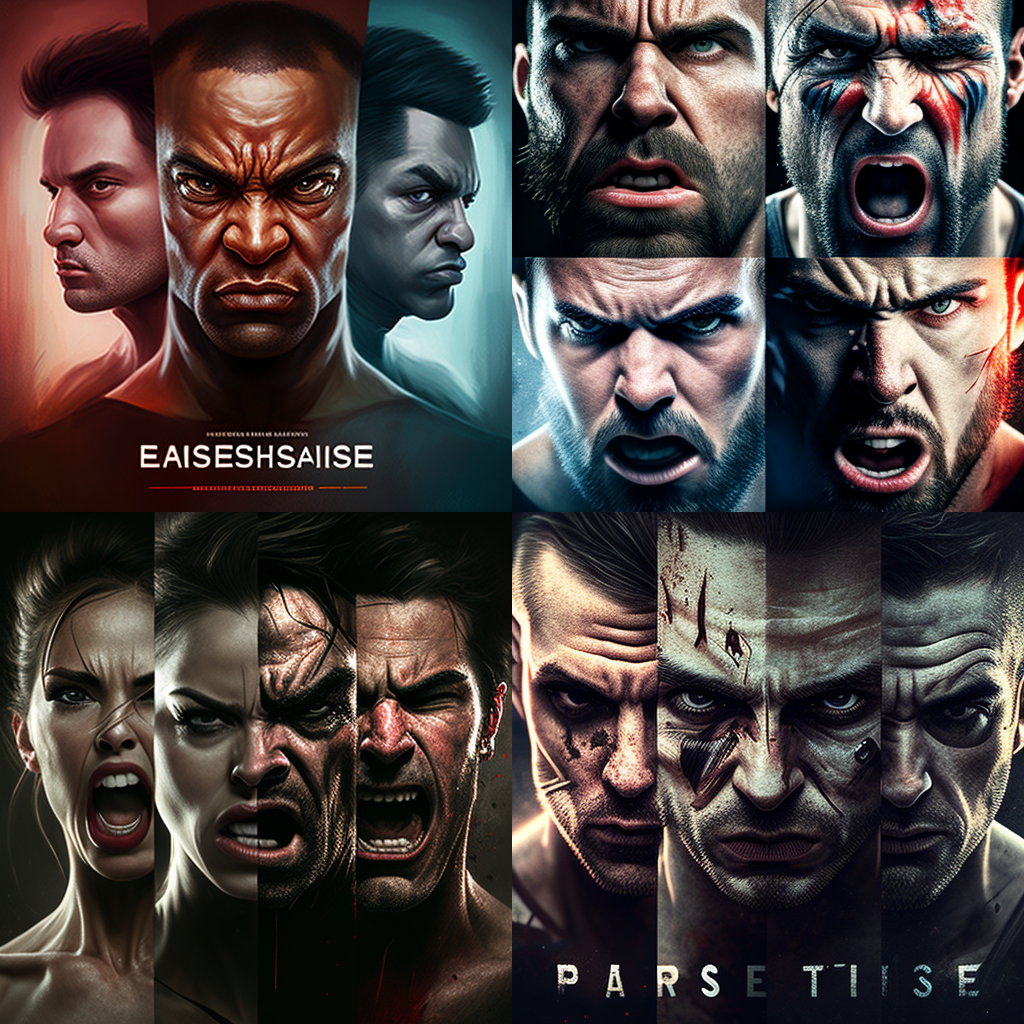

Lockdown

Less Than Jake

['aggressive', 'carefree', 'cheerful', 'gleeful', 'playful', 'energetic']

https://www.youtube.com/watch?v=yilBbdJN3Ss&ab_channel=LessThanJake-Topic

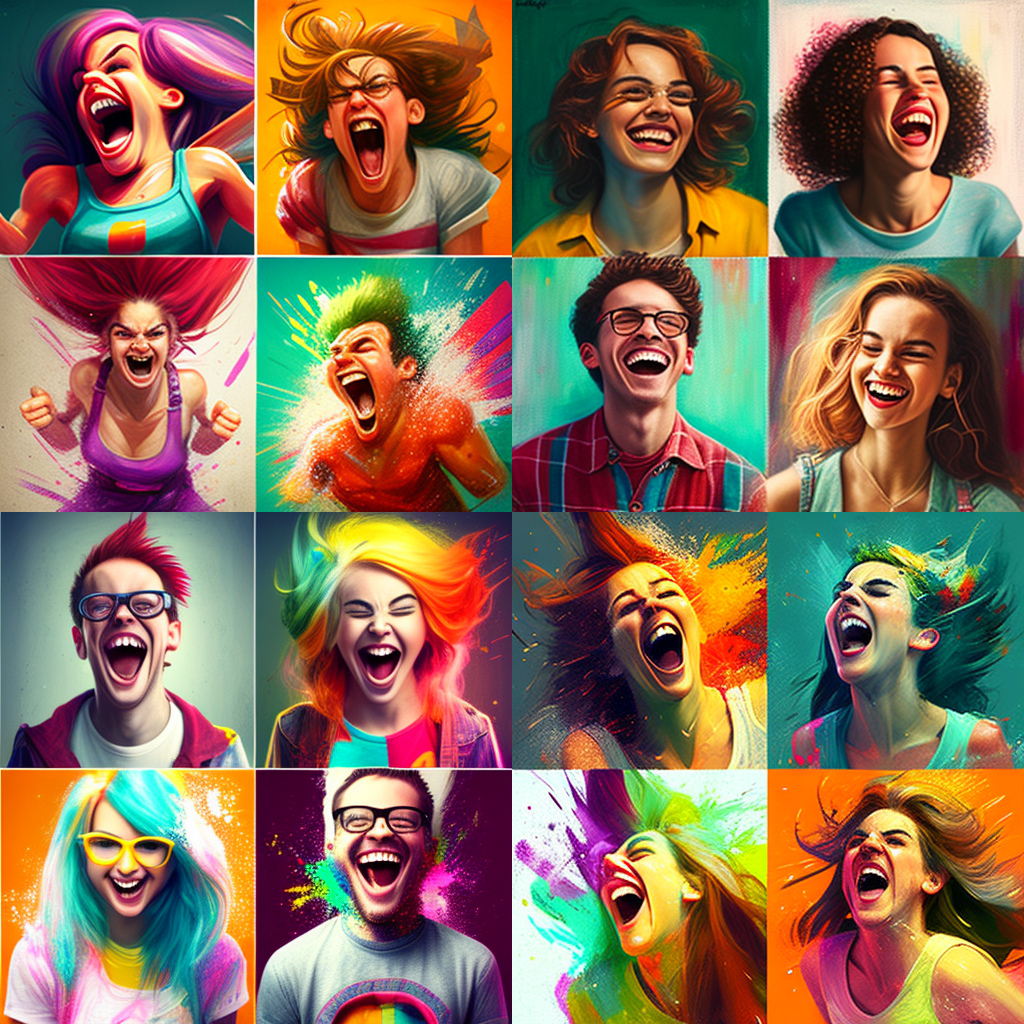

One example of such a dataset is the DEAM (Database for Emotion Analysis using Music) dataset. This dataset contains audio files of music tracks along with annotations for valence, arousal, and dominance, as well as categorical labels for emotions such as "aggressive", "carefree", "cheerful", "gleeful", "playful", "energetic", and many others.

The dataset also includes additional information such as artist and song metadata, lyrics, and self-reported emotional responses from participants who listened to the music tracks.

You can download the DEAM dataset from the following website:

http://cvml.unige.ch/databases/DEAM/

The website also provides code for loading and processing the dataset in Python, as well as several pre-trained models for emotion recognition from music.

Note that the DEAM dataset is a relatively large and complex dataset, so it may require some preprocessing and feature extraction before it can be used with machine learning models.